# ChemTab (PCDNN_V2) Benchmark Notebook
### This notebook contains experiments around the different parameters for the model
#### Amol Salunkhe

Develop a deep neural architecture ChemTab that jointly optimizes two neural networks for the tasks of reduced basis learning (encoder) and reverse lookup function learning (regressor). The first network (Shallow AutoEncoder) will focus on linear dimensionality reduction and create a linear embedding for the source species. The second network (Deep Regressor) will focus on learning a lookup function from the linear embedding to the Thermo-chemical state variables.

### Overall Problem Formulation

\begin{equation}\label{eqn:lossfunc}
    \begin{aligned}
    \textrm{min} \quad \mathcal{L}_{joint} = \lambda_{encoder} * \mathcal{L}_{encoder} + \lambda_{regressor}* \mathcal{L}_{regressor} 
    \end{aligned}
\end{equation}

### Reduced Basis Problem Formulation (Encoder)

\begin{equation}\label{eqn:Reduced-Basis-Learning}
    \begin{aligned}
    \def\sss{\scriptscriptstyle}
    {}
    \def\stacktype{L}
        {\mathrm{Y^{'}}}{\sss n\times k} =  {Y}{\sss n\times s} \times {W}{\sss s\times k} \\
        \textrm{s.t.,} \quad k \ll s\\
        \mathrm{\phi}(Y) \approx \mathrm{\phi}(Y^{'})\\
        \textrm{where, W is the Reduced Basis / encoder} \\
        \mathrm{\phi} \quad \textrm{is the Reverse Lookup function / regressor}
    \end{aligned}
\end{equation}


### Lookup Learning Problem Formulation (Regressor)

\begin{equation}\label{eqn:Reverse-Lookup-Learning}
    \begin{aligned}
        \textrm{min} \quad ||{S_i} - \mathrm{\phi}(Y^{'}_i)||_{p}\\
        \textrm{s.t.,} \quad p \in r \\
        \quad k \ll s\\
        \mathrm{\phi}(Y) \approx \mathrm{\phi}(Y^{'})\\
    \end{aligned}
\end{equation}




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize
from sklearn.utils.optimize import _check_optimize_result
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
import time
from sklearn.decomposition import PCA, SparsePCA
%matplotlib inline
import seaborn as sns
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint
import sys

## Helpers

In [2]:
from benchmark_model_code import * # Network Helpers
from benchmark_data_code import * # Data Helpers
halfData = getHalfData()

Yi_col: ['YiCH4', 'YiH', 'YiO', 'YiO2', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH', 'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiH2', 'YiCO', 'YiCO2', 'YiHCO', 'YiCH2O', 'YiCH2OH', 'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', 'YiC2H5', 'YiC2H6', 'YiHCCO', 'YiCH2CO', 'YiHCCOH', 'YiN', 'YiNH', 'YiNH2', 'YiNH3', 'YiNNH', 'YiNO', 'YiNO2', 'YiN2O', 'YiHNO', 'YiCN', 'YiHCN', 'YiH2CN', 'YiHCNN', 'YiHCNO', 'YiHOCN', 'YiHNCO', 'YiNCO', 'YiC3H7', 'YiC3H8', 'YiCH2CHO', 'YiCH3CHO', 'YiN2', 'YiAR']
53
source term cols: ['souspecCH4', 'souspecH', 'souspecO', 'souspecO2', 'souspecOH', 'souspecH2O', 'souspecHO2', 'souspecH2O2', 'souspecC', 'souspecCH', 'souspecCH2', 'souspecCH2(S)', 'souspecCH3', 'souspecH2', 'souspecCO', 'souspecCO2', 'souspecHCO', 'souspecCH2O', 'souspecCH2OH', 'souspecCH3O', 'souspecCH3OH', 'souspecC2H', 'souspecC2H2', 'souspecC2H3', 'souspecC2H4', 'souspecC2H5', 'souspecC2H6', 'souspecHCCO', 'souspecCH2CO', 'souspecHCCOH', 'souspecN', 'souspecNH', 'souspecNH2', 'souspecN

/home/dwyerdei/rom_project2/src/benchmark_data_code.py:284: UserWarning: transparently scaling Zmix!
  warnings.warn('transparently scaling Zmix!')


In [3]:
#df = pd.read_csv('../NewData_flames_data_with_L1_L2_errors_CH4-AIR_without_trimming(SouSpec_Included).txt')
#df=df.drop(columns='YiAR') # drop this because it is inert and has no corresponding source term

In [4]:
Yi_cols = [col for col in df.columns if col[:2]=='Yi']
print(f'Yi_col: {Yi_cols}')
print(len(Yi_cols))
source_term_cols = ['souspec' + col[2:] for col in Yi_cols]
#source_term_cols2 = [col for col in df.columns if col.lower().startswith('souspec')]
print(f'source term cols: {source_term_cols}')
#print(f'source term cols2: {source_term_cols2}')

'''
X_allSpecies = df[Yi_cols].values
X_allSources = df[source_term_cols].values
Y_souener = df['souener']
speciesInputScaler = MinMaxScaler
sourcesInputScaler = MinMaxScaler
souenerOutputScaler = MinMaxScaler
'''

Yi_col: ['YiCH4', 'YiH', 'YiO', 'YiO2', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH', 'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiH2', 'YiCO', 'YiCO2', 'YiHCO', 'YiCH2O', 'YiCH2OH', 'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', 'YiC2H5', 'YiC2H6', 'YiHCCO', 'YiCH2CO', 'YiHCCOH', 'YiN', 'YiNH', 'YiNH2', 'YiNH3', 'YiNNH', 'YiNO', 'YiNO2', 'YiN2O', 'YiHNO', 'YiCN', 'YiHCN', 'YiH2CN', 'YiHCNN', 'YiHCNO', 'YiHOCN', 'YiHNCO', 'YiNCO', 'YiC3H7', 'YiC3H8', 'YiCH2CHO', 'YiCH3CHO', 'YiN2', 'YiAR']
53
source term cols: ['souspecCH4', 'souspecH', 'souspecO', 'souspecO2', 'souspecOH', 'souspecH2O', 'souspecHO2', 'souspecH2O2', 'souspecC', 'souspecCH', 'souspecCH2', 'souspecCH2(S)', 'souspecCH3', 'souspecH2', 'souspecCO', 'souspecCO2', 'souspecHCO', 'souspecCH2O', 'souspecCH2OH', 'souspecCH3O', 'souspecCH3OH', 'souspecC2H', 'souspecC2H2', 'souspecC2H3', 'souspecC2H4', 'souspecC2H5', 'souspecC2H6', 'souspecHCCO', 'souspecCH2CO', 'souspecHCCOH', 'souspecN', 'souspecNH', 'souspecNH2', 'souspecN

"\nX_allSpecies = df[Yi_cols].values\nX_allSources = df[source_term_cols].values\nY_souener = df['souener']\nspeciesInputScaler = MinMaxScaler\nsourcesInputScaler = MinMaxScaler\nsouenerOutputScaler = MinMaxScaler\n"

### Constrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding; All Constraints)

In [5]:
encoding_dim = 4
n_species = len(Yi_cols) # only 52

def get_source_term_truth_model(W_emb_layer):
    source_term_inputs = keras.Input(shape=(n_species,), name='source_term_input')
    source_term_truth = W_emb_layer(source_term_inputs)
    source_term_truth_model = keras.Model(inputs=source_term_inputs, outputs=source_term_truth, name='source_term_truth')
    return source_term_truth_model

species_inputs = keras.Input(shape=(n_species,), name="species_input")
source_term_inputs = keras.Input(shape=(n_species,), name='source_term_input')
Zmix = keras.Input(shape=(1,), name="Zmix")

W_emb_layer = layers.Dense(encoding_dim, activation="linear",kernel_constraint=UnitNorm(axis=0),
                 kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0),
                 activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.))

# use same layer to compute real source_terms as 
x = W_emb_layer(species_inputs)
source_term_truth_model = get_source_term_truth_model(W_emb_layer)
source_term_truth = source_term_truth_model(source_term_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

#Predict the source energy
souener_pred = layers.Dense(1, name="souener_prediction")(x)
source_term_pred = layers.Dense(encoding_dim, name='source_term_pred')(x)

# TODO: use me
#base_regression_model = keras.Model(inputs=[species_inputs], outputs=[souener_pred, source_term_pred])

# QUESTION: how to use loss that doesn't compare with actual training data?
source_term_all = layers.Concatenate(name='source_term_all')([source_term_pred, source_term_truth])

model = keras.Model(
    inputs=[species_inputs,Zmix,source_term_inputs],
    outputs=[souener_pred,source_term_all],
)

def source_term_loss(y_true, y_pred):
    #import pdb; pdb.set_trace()
    #assert len(y_pred.shape)==1
    abs_diff = tf.math.abs(y_pred[:,:encoding_dim]-y_pred[:,encoding_dim:])
    #squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(abs_diff, axis=-1)  # Note the `axis=-1`

#losses='mae' # TODO: use me again for simple model
losses={'souener_prediction': 'mae', 'source_term_all': source_term_loss}

#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 species_input (InputLayer)     [(None, 53)]         0           []                               
                                                                                                  
 Zmix (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 4)            216         ['species_input[0][0]']          
                                                                                                  
 concatenate (Concatenate)      (None, 5)            0           ['Zmix[0][0]',                   
                                                                  'dense[0][0]']              

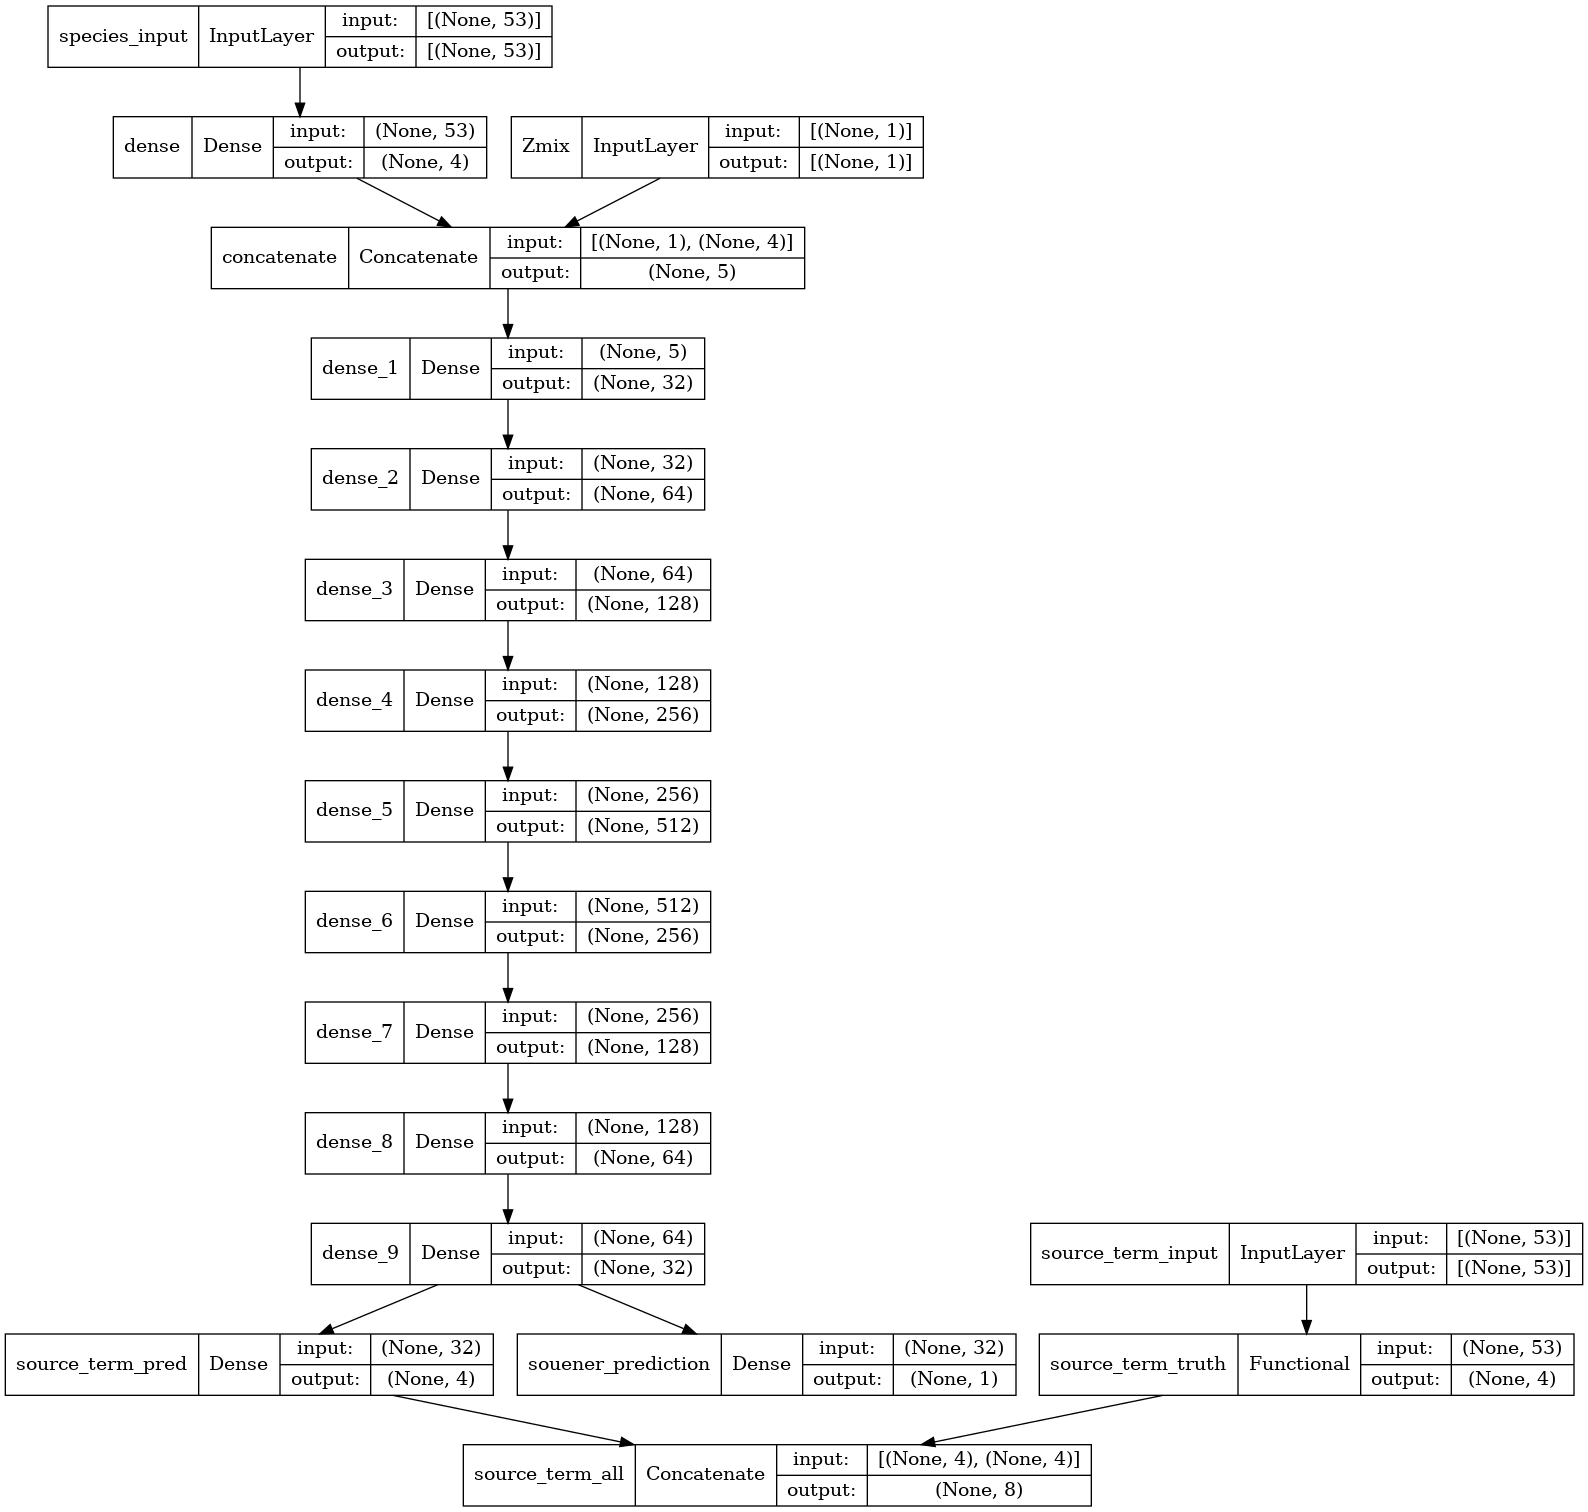

In [6]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [38]:
def R2(yt,yp): return 1-tf.math.reduce_mean((yp-yt)**2)/(tf.math.reduce_std(yt)**2)
def R2_split(yt,yp):
    yt=yp[:,encoding_dim:]
    yp=yp[:,:encoding_dim]
    return 1-tf.math.reduce_mean((yp-yt)**2)/(tf.math.reduce_std(yt)**2)
metrics = [R2,R2_split]
model.compile(loss=losses,optimizer=tf.keras.optimizers.Adam(0.001), metrics=metrics)

In [40]:
%%time

normalized_species_train = halfData["normalized_species_train"]
normalized_sources_train = halfData['normalized_sources_train']
Zmix_train = halfData["Zmix_train"]
normalized_souener_train = halfData["normalized_souener_train"]

dummy_source_term_data = np.zeros(shape=(normalized_souener_train.shape[0],8))

history = model.fit({'species_input': normalized_species_train,'Zmix': Zmix_train, 'source_term_input': normalized_sources_train}, 
                     {'souener_prediction': normalized_souener_train, 'source_term_all': dummy_source_term_data},
                     validation_split=0.2,
                     verbose=1, 
                     epochs=100,
                     batch_size=64,
                     callbacks=[es])

Epoch 1/100
103/103 [==============================] - 1s 14ms/step - loss: 0.0067 - souener_prediction_loss: 0.0016 - source_term_all_loss: 0.0021 - souener_prediction_R2: 0.9990 - souener_prediction_R2_split: nan - source_term_all_R2: -inf - source_term_all_R2_split: 0.9895 - val_loss: 0.0053 - val_souener_prediction_loss: 0.0018 - val_source_term_all_loss: 0.0019 - val_souener_prediction_R2: 0.9985 - val_souener_prediction_R2_split: nan - val_source_term_all_R2: -inf - val_source_term_all_R2_split: 0.9841
Epoch 2/100
103/103 [==============================] - 1s 14ms/step - loss: 0.0050 - souener_prediction_loss: 0.0015 - source_term_all_loss: 0.0020 - souener_prediction_R2: 0.9990 - souener_prediction_R2_split: nan - source_term_all_R2: -inf - source_term_all_R2_split: 0.9895 - val_loss: 0.0052 - val_souener_prediction_loss: 0.0015 - val_source_term_all_loss: 0.0024 - val_souener_prediction_R2: 0.9977 - val_souener_prediction_R2_split: nan - val_source_term_all_R2: -inf - val_sourc

Epoch 17/100
103/103 [==============================] - 1s 14ms/step - loss: 0.0052 - souener_prediction_loss: 0.0015 - source_term_all_loss: 0.0018 - souener_prediction_R2: 0.9992 - souener_prediction_R2_split: nan - source_term_all_R2: -inf - source_term_all_R2_split: 0.9917 - val_loss: 0.0045 - val_souener_prediction_loss: 0.0013 - val_source_term_all_loss: 0.0018 - val_souener_prediction_R2: 0.9986 - val_souener_prediction_R2_split: nan - val_source_term_all_R2: -inf - val_source_term_all_R2_split: 0.9818
Epoch 18/100
103/103 [==============================] - 1s 14ms/step - loss: 0.0051 - souener_prediction_loss: 0.0016 - source_term_all_loss: 0.0022 - souener_prediction_R2: 0.9991 - souener_prediction_R2_split: nan - source_term_all_R2: -inf - source_term_all_R2_split: 0.9894 - val_loss: 0.0045 - val_souener_prediction_loss: 0.0013 - val_source_term_all_loss: 0.0019 - val_souener_prediction_R2: 0.9983 - val_souener_prediction_R2_split: nan - val_source_term_all_R2: -inf - val_sou

Epoch 33/100
103/103 [==============================] - 2s 15ms/step - loss: 0.0046 - souener_prediction_loss: 0.0016 - source_term_all_loss: 0.0018 - souener_prediction_R2: 0.9990 - souener_prediction_R2_split: nan - source_term_all_R2: -inf - source_term_all_R2_split: 0.9913 - val_loss: 0.0053 - val_souener_prediction_loss: 0.0017 - val_source_term_all_loss: 0.0024 - val_souener_prediction_R2: 0.9984 - val_souener_prediction_R2_split: nan - val_source_term_all_R2: -inf - val_source_term_all_R2_split: 0.9805
Epoch 34/100
103/103 [==============================] - 1s 14ms/step - loss: 0.0053 - souener_prediction_loss: 0.0017 - source_term_all_loss: 0.0019 - souener_prediction_R2: 0.9990 - souener_prediction_R2_split: nan - source_term_all_R2: -inf - source_term_all_R2_split: 0.9895 - val_loss: 0.0069 - val_souener_prediction_loss: 0.0030 - val_source_term_all_loss: 0.0020 - val_souener_prediction_R2: 0.9959 - val_souener_prediction_R2_split: nan - val_source_term_all_R2: -inf - val_sou

Epoch 49/100
103/103 [==============================] - 1s 14ms/step - loss: 0.0045 - souener_prediction_loss: 0.0015 - source_term_all_loss: 0.0018 - souener_prediction_R2: 0.9991 - souener_prediction_R2_split: nan - source_term_all_R2: -inf - source_term_all_R2_split: 0.9926 - val_loss: 0.0061 - val_souener_prediction_loss: 0.0015 - val_source_term_all_loss: 0.0024 - val_souener_prediction_R2: 0.9976 - val_souener_prediction_R2_split: nan - val_source_term_all_R2: -inf - val_source_term_all_R2_split: 0.9812
Epoch 50/100
103/103 [==============================] - 1s 14ms/step - loss: 0.0049 - souener_prediction_loss: 0.0015 - source_term_all_loss: 0.0018 - souener_prediction_R2: 0.9992 - souener_prediction_R2_split: nan - source_term_all_R2: -inf - source_term_all_R2_split: 0.9931 - val_loss: 0.0060 - val_souener_prediction_loss: 0.0020 - val_source_term_all_loss: 0.0019 - val_souener_prediction_R2: 0.9961 - val_souener_prediction_R2_split: nan - val_source_term_all_R2: -inf - val_sou

Epoch 65/100
103/103 [==============================] - 1s 14ms/step - loss: 0.0049 - souener_prediction_loss: 0.0017 - source_term_all_loss: 0.0019 - souener_prediction_R2: 0.9988 - souener_prediction_R2_split: nan - source_term_all_R2: -inf - source_term_all_R2_split: 0.9920 - val_loss: 0.0050 - val_souener_prediction_loss: 0.0016 - val_source_term_all_loss: 0.0021 - val_souener_prediction_R2: 0.9986 - val_souener_prediction_R2_split: nan - val_source_term_all_R2: -inf - val_source_term_all_R2_split: 0.9831
Epoch 66/100
103/103 [==============================] - 1s 14ms/step - loss: 0.0051 - souener_prediction_loss: 0.0018 - source_term_all_loss: 0.0020 - souener_prediction_R2: 0.9988 - souener_prediction_R2_split: nan - source_term_all_R2: -inf - source_term_all_R2_split: 0.9918 - val_loss: 0.0062 - val_souener_prediction_loss: 0.0029 - val_source_term_all_loss: 0.0020 - val_souener_prediction_R2: 0.9956 - val_souener_prediction_R2_split: nan - val_source_term_all_R2: -inf - val_sou

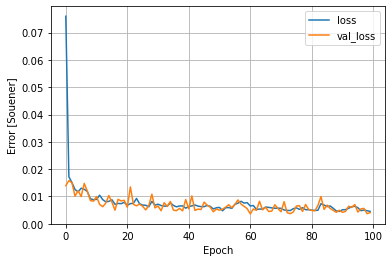

In [13]:
plot_loss(history)

In [29]:
normalized_species_test = halfData["normalized_species_test"]
normalized_sources_test = halfData['normalized_sources_test']

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict({'species_input': normalized_species_test,'Zmix': Zmix_test, 'source_term_input': normalized_sources_test})[0]

normalized_souener_pred = predictions

In [30]:
scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)
Y_pred = Y_pred.flatten()
Y_test = halfData["Y_test"]

In [33]:
err = computeAndPrintError(Y_pred, Y_test)

def print_scientific_notation(number):
    power = int(np.log(number)/np.log(10))
    print(f"Scientific Notation: {(number/10**power)}*10^{power}")
print_scientific_notation(615230621.10611)

Total Absolute Error:  5058426166734.437
Mean Absolute Error:  615230621.10611
Mean Percentage Error:  62.08635555097395
Total Squared Error:  3.6513484543220305e+22
Mean Squared Error:  4.4409492268572493e+18
Number of Points:  8222
Scientific Notation: 6.1523062110610995*10^8


In [21]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

NameError: name 'sns' is not defined

## RESULTS SUMMARY

<table>
<tr>
<td>Method </td>
<td>MAE</td>
</tr>
<tr>
<td>Framework </td>
<td>2.24 E+09</td>
</tr>
<tr>
<td>DNN (Non-Linear Embedding) </td>
<td>9.304 E+08</td>
</tr>    
<tr>
<td>DNN (Linear Embedding [No Constraints]) </td>
<td>2.042 E+09</td>
</tr>       
<tr>
<td>ChemTab (Unit Norm Constraints) </td>
<td>6.28 E+08</td>
</tr>
<tr>
<td>ChemTab (Orthogonal Weights Constraints) </td>
<td>6.05 E+08</td>
</tr>
<tr>
<td>ChemTab (Uncorrelated Features Constraints) </td>
<td>5.7 E+08</td>
</tr>
<tr>
<td>ChemTab (All Constraints) </td>
<td>8.008 E+08</td>
</tr>
    
</table>